## Libraries

In [10]:
import pandas as pd
import time as time
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sb; 
sb.set()
%matplotlib inline

## Variables

Number of simulations is based on errors O(δt) and O(N ** -.5)

In [11]:
S0 = 100
E = 100
T = 1 # year
r = 0.05
s = .2

nr_of_timesteps = 252 # days in year
delta_t = T / nr_of_timesteps

nr_of_simulations = int((1/delta_t)**2)

error = 1 / np.sqrt(nr_of_simulations)
print('Number of simulations is: {}'.format(nr_of_simulations))
print('Error is: {}'.format(error))

Number of simulations is: 63504
Error is: 0.003968253968253968


## Functions

- calc_return_EM: function for calculation random returns using Euler-Maruyama
- calc_return_CF: function for calculation random returns using closed form solution
- calc_stock_prices: function for calculating future stock prices using Monte Carlo simulations
- mc_binary_price: function for calculating a binary option price using Monte Carlo simulation output
- black_scholes_binary: function for calculating a binary option price using the Black Scholes function

In [12]:
def calc_return_EM(r, s, delta_t):
    """
    function for calculating random returns using Euler-Maruyama
    
    r: risk free rate
    s: volatility
    delta_t: timestep
    """
    
    f = r * delta_t + s * np.random.normal(0, np.sqrt(delta_t))

    return  1 + f


def calc_return_CF(r, s, delta_t):
    """
    closed form solution for calculating random returns
    
    r: risk free rate
    s: volatility
    delta_t: timestep
    """
    
    f = np.exp((r - 0.5 * (s**2)) * delta_t + s * np.random.normal(0, 1) * np.sqrt(delta_t))
    
    return f


def calc_stock_prices(r, s, delta_t, nr_of_timesteps, nr_of_simulations, method):
    """
    function for calculating future stock prices using Monte Carlo
    
    r: risk free rate
    s: volatility
    delta_t: timestep
    nr_of_timesteps: total number of delta_ts (T/delta_t)
    nr_of_simulations: number of simulations
    method: option between Euler-Maruyama and Closed Form Solution
    """
    
    # calculate random returns depending on methodology (Euler Maruyama or closed form)
    if method == 'EM':
        random_returns = np.array([calc_return_EM(r,s,delta_t) for x in np.zeros([nr_of_timesteps * nr_of_simulations, 1])])
    elif method == 'CF':
        random_returns = np.array([calc_return_CF(r,s,delta_t) for x in np.zeros([nr_of_timesteps * nr_of_simulations, 1])])
        
    # reshape to size nr_of_timesteps * nr_of_simulations
    returns = random_returns.reshape(nr_of_timesteps, nr_of_simulations)

    # create array for stock prices with the same size as R
    stock_prices = np.zeros_like(returns)

    # set initial stockprice to S0
    stock_prices[0] = S0

    # calculate returns in array stock_prices
    for x in range(1, stock_prices.shape[0]): 
        stock_prices[x,:] = stock_prices[x-1,:] * returns[x,:]
        
    return stock_prices


def mc_binary_price(E, r, T, prices, type='call'):
    """
    function for calculating binary option price using Monte Carlo simulation output.
    
    Determine payoff of the simulated stock prices. 
        Call option: payoff in case simulated stock prices (St) are higher than the strike price.
        Put option: payoff in case simulated stock prices (St) are lower than the strike price.
    Use heaviside function to 'transform' to binary. '0.5' variable in the heaviside function is used to make sure that 
        the result is 0 in case the stock price is equal to the strike price.)
    Calculate average payoff
    Calculate present value of average payoff using risk free interest rate
    
    E:    expected stock price
    r:    risk free rate
    T:    time
    prices: list of simulated stock prices resulting from Monte Carlo simulation
    type: call or put, default is call
    """
    if type == 'call':
        result = np.mean([max(np.around(np.heaviside(x-E, .5)), 0) for x in prices]) * np.exp(-r * T)
    elif type == 'put':
        result = np.mean([max(np.around(np.heaviside(E-x, .5)), 0) for x in prices]) * np.exp(-r * T)
    
    return result
    

def black_scholes_binary(S0, E, r, s, T, type='call'):
    """
    function for calculating a binary option using the Black Scholes function
    
    S0:   current stock price
    E:    expected stock price
    r:    risk free rate
    s:    volatility
    T:    time
    type: call or put, default is call
    """
    d2 = (np.log(S0/E) + (r - 0.5 * s**2) * T) / (s*np.sqrt(T))
    
    if type == 'call':
        result = np.exp(-r * T) * norm.cdf(d2)
    elif type == 'put':
        result = np.exp(-r * T) * (1 - norm.cdf(d2))
    
    return result 


## Calculate future stock prices

- show graphs of Monte Carlo simulations using Euler Maruyama

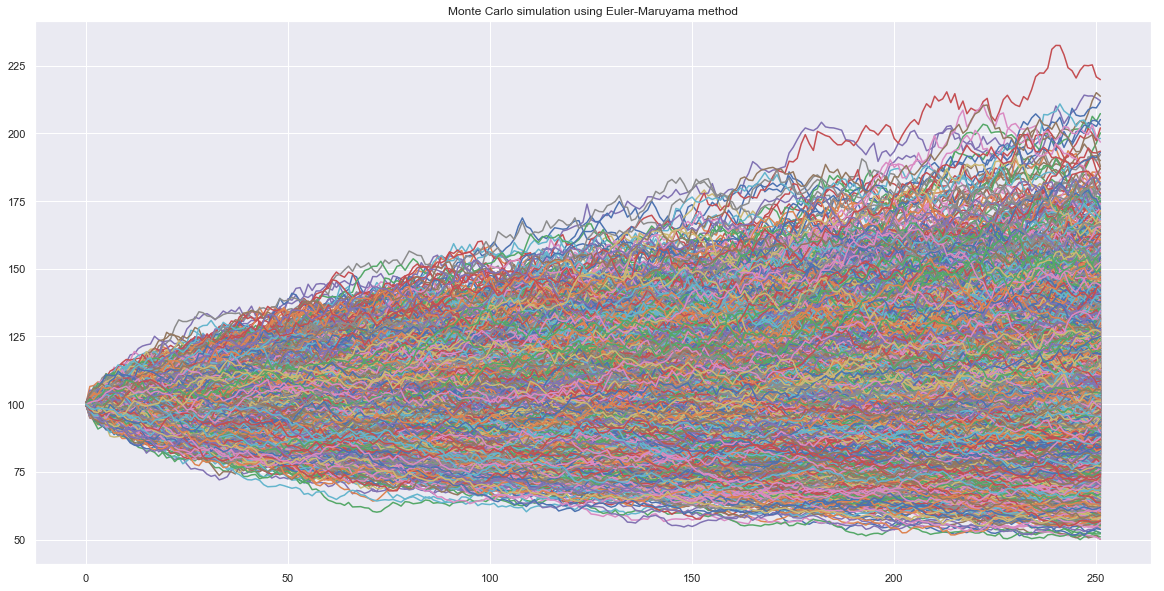

In [13]:
# making a graph with > 60000 simulations is appearantly a bit too much for my computer's processor, hence 10000.
plotdata = calc_stock_prices(r, s, delta_t, nr_of_timesteps, 10000, 'EM')
plt.figure(figsize=(20,10))

for sim in range(plotdata.shape[1]):
    plt.plot(plotdata[:,sim])

plt.title('Monte Carlo simulation using Euler-Maruyama method')
plt.show()

In [14]:
# Monte Carlo using Euler-Maruyama
mc_em_data = calc_stock_prices(r, s, delta_t, nr_of_timesteps, nr_of_simulations, 'EM')
# retrieve stock prices at T
mc_em_out = mc_em_data[-1,:]

# Monte Carlo using closed form 
mc_cf_data = calc_stock_prices(r, s, delta_t, nr_of_timesteps, nr_of_simulations, 'CF')
# retrieve stock prices at T
mc_cf_out = mc_cf_data[-1,:]

## Analyse results for future stock prices (Euler Maruyama)

- calculate Z-scores
- plot PDF of Z-scores in histogram to observe distribution
- plot stock prices at T in histogram to observe distribution

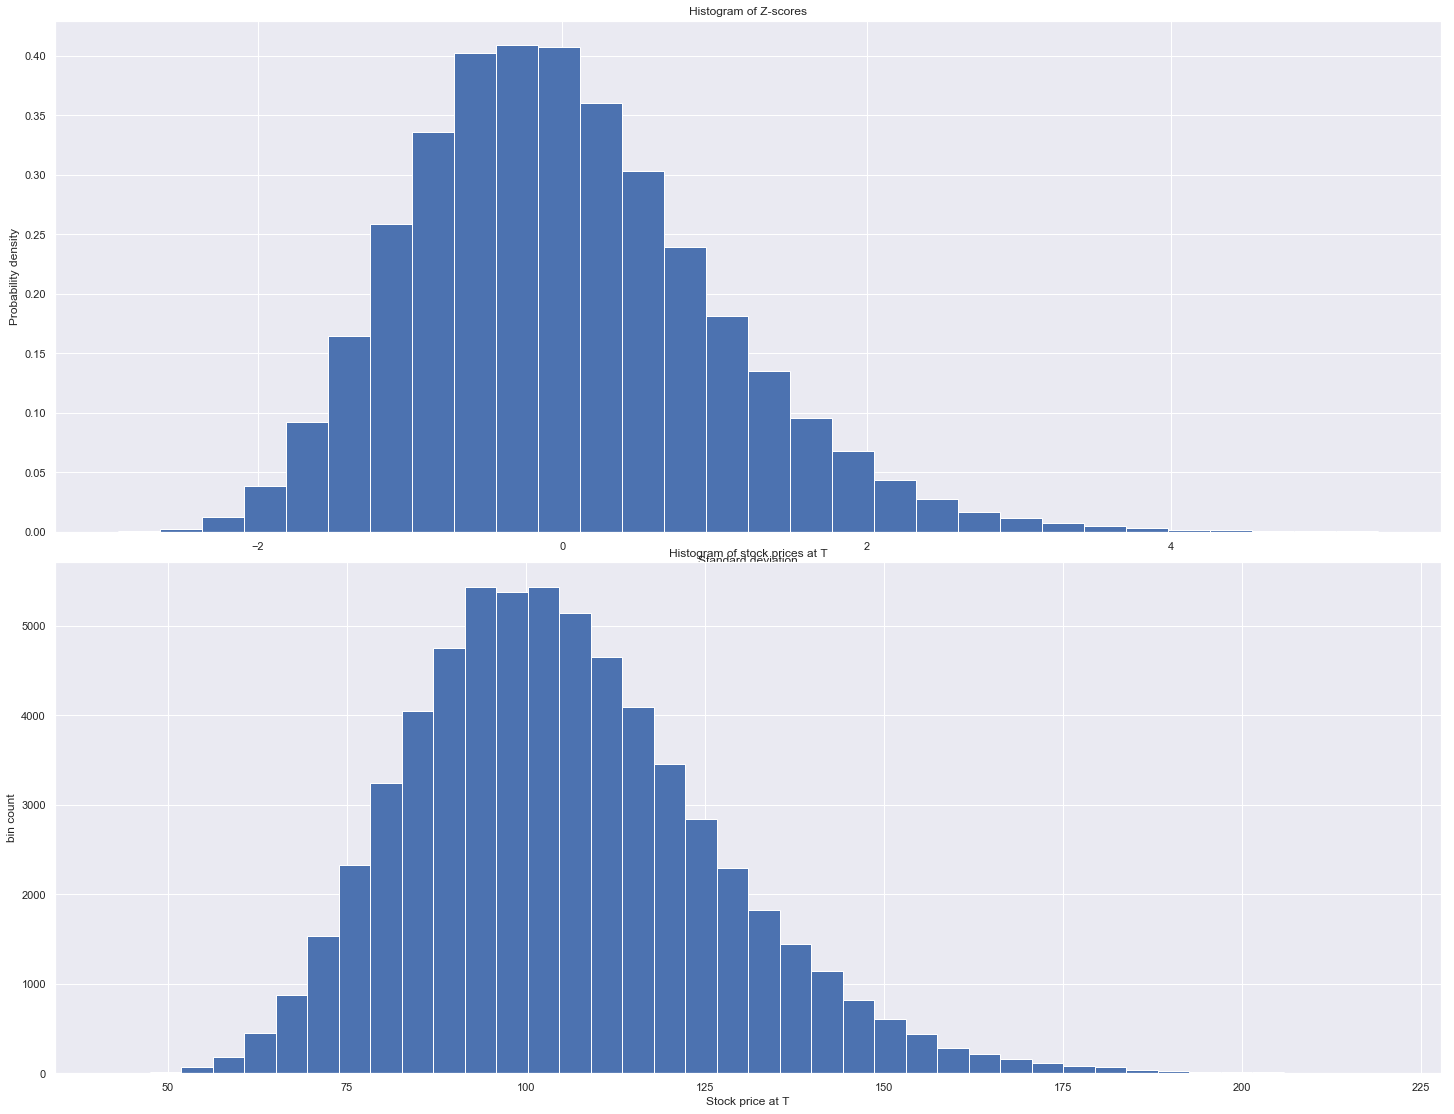

In [15]:
# calculate z-scores for Euler Maruyama method
out = mc_em_data[-1,:]
mean = out.mean()
std = out.std()
zscore = (out - mean) / std

# plot z-scores in histogram (to see if they are normally distributed)
plt.figure(figsize=(20,15))
plt.tight_layout()
plt.subplot(2, 1, 1)
plt.tight_layout()
plt.title('Histogram of Z-scores')
plt.xlabel('Standard deviation')
plt.ylabel('Probability density')
plt.hist(zscore, 30, density=True)

# plot stock prices at T in histogram 
plt.subplot(2, 1, 2)
plt.title('Histogram of stock prices at T')
plt.xlabel('Stock price at T')
plt.ylabel('bin count')
plt.hist(out, 40, density=False)
plt.show()

## Calculate option prices

- Monte Carlo using Euler Maruyama
- Monte Carlo using closed form solution
- Black Scholes 

Return results in dataframe

In [16]:
cf_call = round(mc_binary_price(E, r, T, mc_cf_out, 'call'), 5)
mc_call = round(mc_binary_price(E, r, T, mc_em_out, 'call'), 5)
bs_call = round(black_scholes_binary(S0, E, r, s, T, 'call'), 5)
cf_put = round(mc_binary_price(E, r, T, mc_cf_out, 'put'), 5)
mc_put = round(mc_binary_price(E, r, T, mc_em_out, 'put'), 5)
bs_put = round(black_scholes_binary(S0, E, r, s, T, 'put'), 5)

call = [cf_call, mc_call, bs_call]
put = [cf_put, mc_put, bs_put]
method = ['monte carlo using closed form','monte carlo using euler maruyama', 'black scholes']

df = pd.DataFrame({'method': method, 'call': call, 'put': put})
df

,method,call,put
0,monte carlo using closed form,0.53195,0.41928
1,monte carlo using euler maruyama,0.53213,0.41910
2,black scholes,0.53232,0.41890


All 3 methods for call options return prices around 0.53 and put options prices around 0.42

## Accuracy

I ran several Monte Carlo simulations for binary call options with a varying number of simulations, ranging from 1000 to 80000. The graph below shows that the option price converges to approx. 0.53  
(graph is based on data from several csv files. To recalculate the graph you would have to re-run all simulations using the code below)

In [8]:
# run multiple simulation withs varying numbers 
simulations = list([10000])
errors = []
payoffs = []
    
for sim in simulations:    
    errors.append(1 / np.sqrt(sim))
    x = calc_stock_prices(r, s, delta_t, nr_of_timesteps, sim, 'EM')
    x = x[-1,:]
    call_mean_payoff = np.mean([max(np.around(np.heaviside(St-E, .5)), 0) for St in x])
    call_pv_payoff = call_mean_payoff * np.exp(-r * T)
    payoffs.append(call_pv_payoff)
    
filename = 'results_' + str(int(time.time())) + '.csv'
df = pd.DataFrame({'simulations': simulations, 'errors': errors, 'payoff': payoffs})
df.to_csv(filename, index=False)

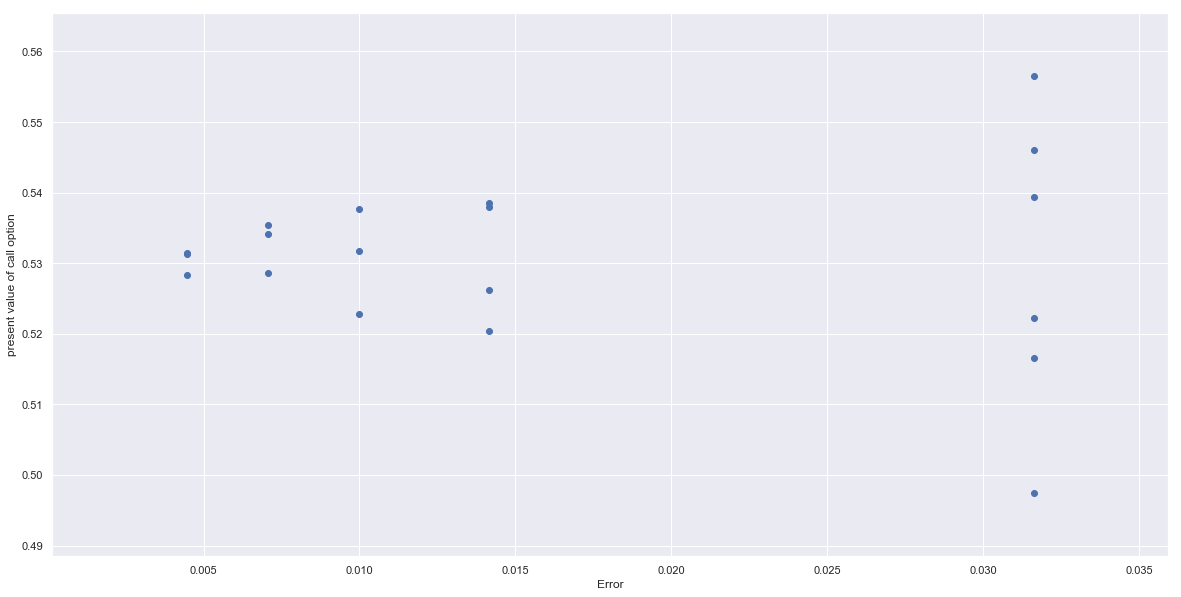

In [9]:
all_files = glob.glob('*.csv')

list_of_files = []
for filename in all_files:
    df1 = pd.read_csv(filename, index_col=None, header=0)
    df1['file'] = filename
    list_of_files.append(df1)

df = pd.concat(list_of_files, axis=0, ignore_index=True)

plt.figure(figsize=(20,10))
plt.scatter(df.errors, df.payoff)
plt.xlabel('Error')
plt.ylabel('present value of call option')
plt.show()